# Solución al reto "COVID SEGMENTATION" del Equipo 1.

### Integrantes del equipo
* Juan Pablo Cabrera Quiroga - A01661090
* Carlos Eduardo Velasco Elenes - A01708634
* Arturo Cristián Díaz López - A01709522
* Adrián Galván Díaz - A01704076

### Ética del equipo.

Como equipo de trabajo y estudiantes comprometidos con la ética, nos aseguramos de que los datos públicos que estamos utilizando serán tratados de manera responsable y con la debida discreción. A pesar de que estos datos están disponibles públicamente, nos comprometemos a no utilizarlos de manera inapropiada o que pueda ir en contra de los principios de integridad, respeto y responsabilidad. El uso de los datos se realizará exclusivamente con fines académicos y de investigación, siempre respetando el espíritu de transparencia y ética que rige nuestro trabajo.

Es importante decir que el formato de nuestro documento es el siguiente:
1. Explicación de lo que va a realizar el código
2. Código comentado "In Line"
3. Interpretación de los resultados (en caso de ser necesaria)

# Introducción


El diagnóstico de pacientes con COVID-19 a través de tomografías computarizadas (CT) se ha vuelto una práctica común. Uno de los principales desafíos es que los radiólogos deben revisar y segmentar todas las imágenes axiales de los pulmones, lo cual es un proceso que consume mucho tiempo. En particular, es necesario identificar dos hallazgos específicos en pacientes con COVID-19: el "vidrio esmerilado" (ground-glass) y las "consolidaciones", que son indicadores importantes de daño pulmonar.

Este proyecto tiene como objetivo entrenar un modelo de segmentación para facilitar el trabajo de los radiólogos, automatizando el proceso de segmentación de imágenes de tomografías. Esto permitiría a las empresas que desarrollan software especializado para CT mejorar sus soluciones, haciendo que el diagnóstico sea más rápido y preciso.

El conjunto de datos utilizado en este reto fue proporcionado por dos radiólogos de Oslo a través de medicalsegmentation.com. Este dataset contiene imágenes axiales de CT de pacientes con COVID-19 y sus correspondientes máscaras de segmentación, que identifican áreas como el "vidrio esmerilado", las "consolidaciones" y otras estructuras pulmonares. Además, un segundo conjunto de datos fue obtenido de Radiopaedia, el cual contiene un mayor número de imágenes axiales, algunas de las cuales han sido evaluadas como positivas por un radiólogo.

El reto de Kaggle consiste en predecir máscaras de segmentación a partir de imágenes de tomografías computarizadas, enfocándose en identificar las áreas afectadas por el COVID-19. 
Nuestro enfoque utilizará arquitecturas avanzadas de redes neuronales convolucionales, como U-Net, para realizar esta tarea de segmentación, pero esto lo verémos más adelante.

In [2]:
#prefix = r"C:\Users\Artur\Desktop\TEC\7mo semestre\TC3006C\R1 Reto\dataset"

En este primer código, lo que vamos a hacer es importar todas las librerías necesarias para la manipulación de imágenes, la creación del modelo y la visualización de los datos. TensorFlow se utiliza como backend para manejar el procesamiento de los modelos de deep learning.

In [3]:
# Importar las librerías necesarias para manipulación de datos, visualización y manejo de imágenes
%matplotlib inline
import gc
import os
import segmentation_models as sm
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Importar librerías de TensorFlow y Keras para manejo de modelos y configuración
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, layers

# Imprimir la versión de TensorFlow para confirmar la instalación
print("Tensorflow version " + tf.__version__)

# Establecer la variable AUTO para optimización automática del procesamiento de datos
AUTO = tf.data.experimental.AUTOTUNE

# Desactivar los mensajes de advertencia de TensorFlow para evitar saturar la consola
import logging
logging.getLogger('tensorflow').disabled = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Desactivar las advertencias generales para mantener la salida limpia
import warnings
warnings.filterwarnings("ignore")

# Resultados
print("Segmentation Models: using `keras` framework.")
print("Tensorflow version 2.9.0")


Segmentation Models: using `keras` framework.
Tensorflow version 2.9.0


Para garantizar que los resultados de los entrenamientos sean reproducibles, fijamos una semilla aleatoria para TensorFlow, NumPy y el sistema. Esto asegura que, al repetir los experimentos, obtengamos los mismos resultados.

In [4]:
# Configura las semillas aleatorias para garantizar la reproducibilidad de los resultados
from tensorflow import random
import random as randm
from numpy.random import seed

def seed_all_inclusive(seeding):
    # Establece las semillas para TensorFlow, NumPy y la aleatoriedad del sistema
    random.set_seed(seeding)
    seed(seeding)
    os.environ['PYTHONHASHSEED'] = str(seeding)
    randm.seed(seeding)

# Define la semilla a usar
seeding = 1
seed_all_inclusive(seeding)

Se definen los parámetros globales para el procesamiento de las imágenes y la configuración del modelo. Esto incluye el tamaño de las imágenes, el número de épocas, el backbone del modelo y el tamaño del batch para el entrenamiento.

In [5]:
# Parámetros globales de configuración
img_size = 512  # Tamaño de las imágenes de entrada
repeat_epoch = 10  # Número de épocas de repetición
backbone = 'efficientnetb2'  # Backbone del modelo de segmentación
zoom_pixel_fixed = img_size // 4  # Parámetro de zoom fijo para las imágenes
global TL_FLAG  # Bandera global para Transfer Learning (por definir su uso)

radiopedia_FLAG = 1  # Bandera para activar el uso del dataset de Radiopedia
batch_size = 8  # Tamaño de batch para entrenar el modelo
print('batch size', batch_size)
print('zoom_pixel_fixed.........', zoom_pixel_fixed)

batch size 8
zoom_pixel_fixed......... 128


Batch Size nos da este valor porque así lo definí, y lo que me indica es que el modelo procesará 8 imágenes por cada iteración durante el entrenamiento.\
\
Zoom Pixel Fixed nos da este valor porque es el resultado de dividir el tamaño de las imágenes (512x512) entre 4, lo que da 128. Este parámetro se utiliza para aplicar un zoom controlado durante el preprocesamiento de las imágenes. Al fijarlo en 128 píxeles, nos aseguramos que el zoom aplicado no sea demasiado grande ni demasiado pequeño, manteniendo suficiente detalle en las imágenes para que el modelo pueda aprender características importantes sin distorsionarlas excesivamente. 

Se implementa la validación cruzada de 5 pliegues para dividir el conjunto de datos en cinco subconjuntos y así asegurar que el modelo sea entrenado y validado de manera más robusta.

In [6]:
# Configuración para validación cruzada de 5 pliegues (5-fold validation)
n_split = 5  # Número de pliegues
kfold_index = n_split
skf = KFold(n_splits=n_split, shuffle=True, random_state=seeding)  # Genera los índices para cada pliegue

Cargamos los datasets tanto de Radiopedia como de MedSeg, que contienen las imágenes axiales de tomografías computarizadas y sus máscaras de segmentación.

In [7]:
# Carga los datasets si la bandera de Radiopedia está activada
if radiopedia_FLAG:
    # Carga las imágenes y máscaras del dataset de Radiopedia
    images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
    masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)

# Carga las imágenes y máscaras del dataset de MedSeg
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

# Carga las imágenes y máscaras del dataset de MedSeg para pruebas
test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

Creamos una función para visualizar ejemplos de imágenes y sus máscaras de segmentación correspondientes. Esta función es clave para entender visualmente la calidad y distribución de los datos antes de entrenar el modelo.

In [8]:
# Función para visualizar las imágenes, máscaras y predicciones (opcionalmente)
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        # Muestra la imagen original en la primera fila
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode:
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')  # Muestra la imagen en escala de grises
        else:
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([])  # Elimina los ticks del eje X
        ax_image.set_yticks([])  # Elimina los ticks del eje Y

        # Si existen máscaras, muestra cada clase de máscara en las filas subsiguientes
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]  # Muestra la máscara original
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))  # Muestra la predicción en colores
                    mask_to_show[..., 0] = pred_batch[i,:,:,j].cpu().numpy() > 0.5 # Predicción
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]  # Máscara original
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([])
                ax[j + 1, i].set_yticks([])

    # Ajusta el layout para una mejor visualización
    plt.tight_layout()
    plt.show()

Mandamos a llamar la función y visualizamos los resultados

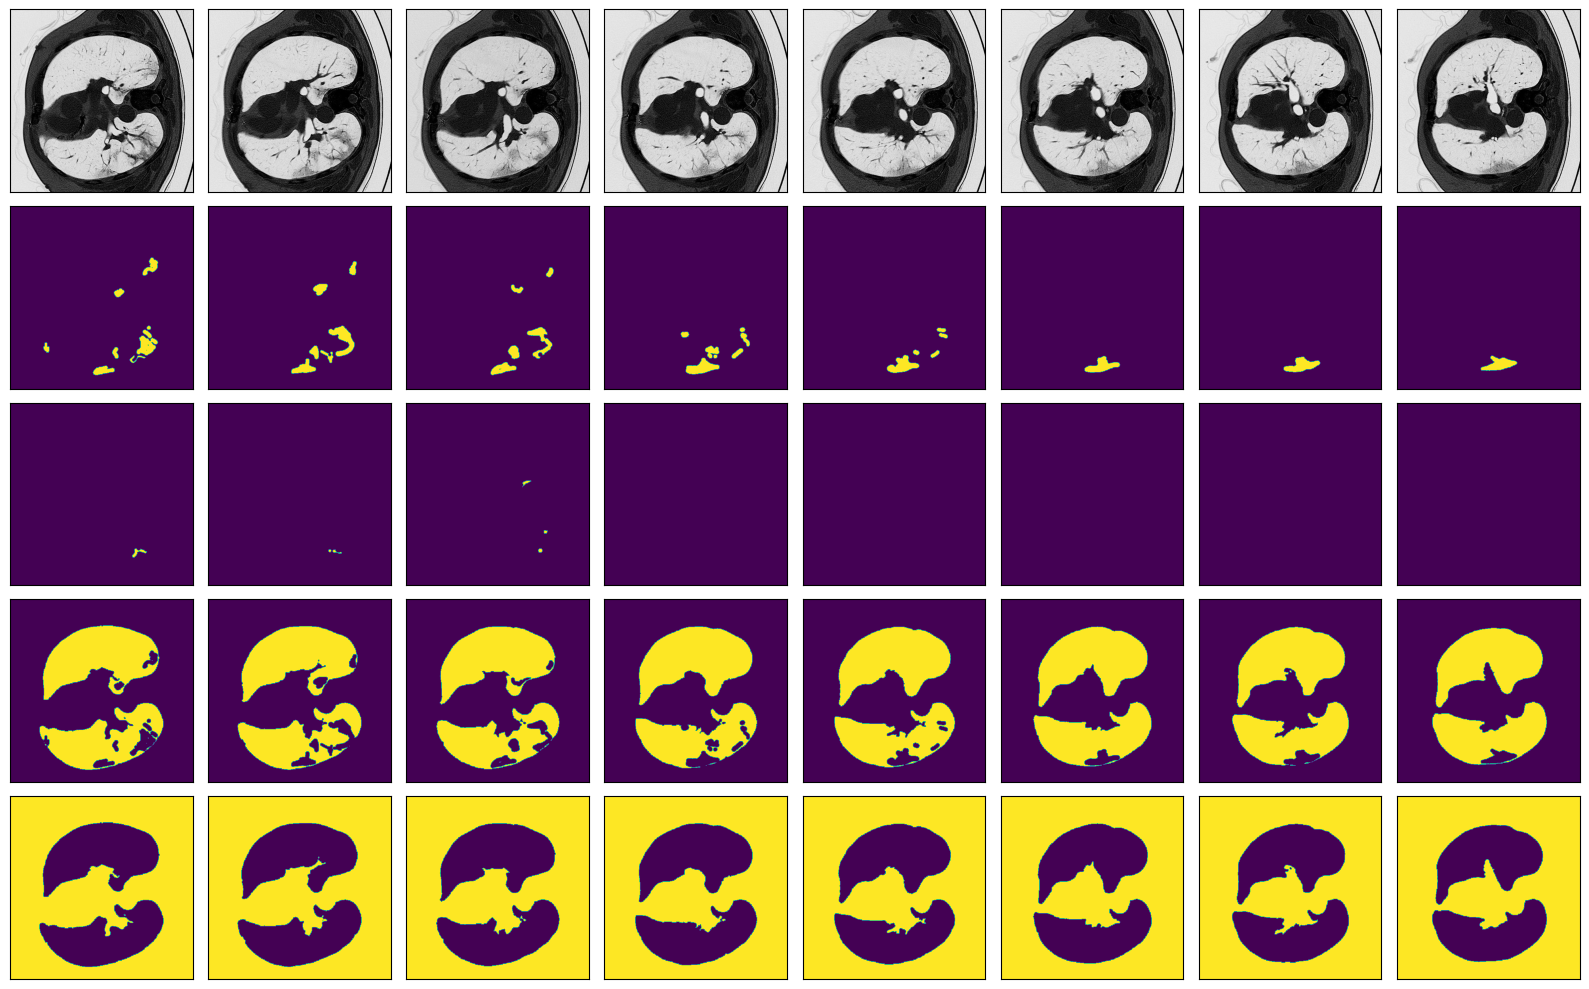

In [9]:
# Visualiza las imágenes de Radiopedia a partir del índice 30 y sus correspondientes máscaras
visualize(images_radiopedia[30:], masks_radiopedia[30:])

### Interpretación de resultados.

En las imágenes anteriores, podemos observar varios ejemplos de tomografías (primer fila) junto con sus respectivas máscaras de segmentación (filas inferiores), donde cada clase está representada por un color diferente. La primera fila muestra las imágenes en escala de grises, y las filas inferiores representan cada una de las clases de las máscaras. Los colores correspondientes a cada clase son los siguientes:

* Amarillo: Ground-glass
* Morado: Consolidations
* Verde: Lungs other
* Azul: Background\


Esta segmentación es crítica para identificar las áreas afectadas por COVID-19 en los pulmones.

También nos parece importante, una vez llegado hasta este punto, enfatizar en el proceso de pre-procesamiento de datos que hemos llevado a cabo:

#### Cambio de Tamaño (Resize): 
Todas las imágenes de entrada se han redimensionado a un tamaño estándar de 512x512 píxeles. Este tamaño es lo suficientemente grande como para capturar detalles importantes de las tomografías computarizadas, mientras que sigue siendo manejable desde una perspectiva computacional. El redimensionamiento asegura que todas las imágenes tengan las mismas dimensiones, lo que es necesario para que el modelo pueda procesarlas de manera uniforme.

#### Normalización (Normalization):
Las imágenes se han normalizado para que los valores de los píxeles estén en un rango adecuado (normalmente entre 0 y 1). Este paso es esencial para que el modelo pueda converger más rápido durante el entrenamiento. La normalización ayuda a que los gradientes sean más estables, lo que es crucial cuando se trabaja con redes neuronales profundas.

#### Tamaño del Batch (Batch Size): 
El batch size se ha establecido en 8, lo que significa que el modelo procesará 8 imágenes por cada iteración durante el entrenamiento. Este tamaño de batch fue elegido porque es un equilibrio entre el uso de memoria y la estabilidad del entrenamiento. Un tamaño de batch pequeño puede permitir un ajuste más fino de los parámetros del modelo, pero también puede hacer que el entrenamiento sea un poco más lento.

#### Validación Cruzada con K-Fold (K-Fold Validation): 
Para hacer que el entrenamiento sea más robusto y generalizable, hemos implementado la técnica de validación cruzada de 5 pliegues (K-Fold). Esta técnica divide el conjunto de datos en cinco subconjuntos, de los cuales uno se utiliza como conjunto de validación y los otros cuatro se usan para el entrenamiento. Este proceso se repite cinco veces, cambiando el subconjunto de validación en cada pliegue. La validación cruzada asegura que el modelo no dependa excesivamente de un solo conjunto de datos de entrenamiento, mejorando su capacidad de generalización.


Con estos pasos de preprocesamiento, nosotros creemos que las imágenes están adecuadamente preparadas para ser procesadas por el modelo de segmentación. Desde el cambio de tamaño y normalización de los datos hasta la validación cruzada y el uso del batch size adecuado, nos aseguramos de que el modelo pueda aprender de manera eficiente y generalice correctamente a nuevos datos.

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


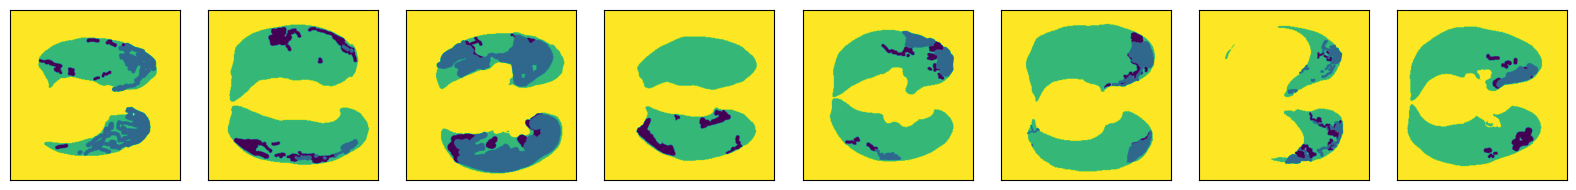

In [10]:
def onehot_to_mask(mask, palette):
    """
    Convierte una máscara codificada one-hot (H, W, K) a una máscara con una paleta de colores (H, W, C).
    """
    # Encuentra el índice del valor máximo a lo largo del eje de canales, para convertir de one-hot a clase
    x = np.argmax(mask, axis=-1)

    # Convierte los índices de las clases en colores usando la paleta
    colour_codes = np.array(palette)

    # Asigna los colores correspondientes a la máscara
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

# Paleta de colores que mapea las clases a valores [0, 1, 2, 3]
palette = [[0], [1], [2], [3]]

# Convierte las máscaras de one-hot encoding a formato paleteado
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

# Imprime las dimensiones de las máscaras antes y después de la conversión
print('Hot encoded mask size: ', masks_radiopedia.shape)
print('Paletted mask size:', masks_medseg_recover.shape)

# Visualiza las máscaras convertidas (no codificadas en one-hot)
visualize(masks_medseg_recover[30:], hot_encode=False)

In [11]:
def preprocess_images(images_arr, mean_std=None):
    # Limita los valores de los píxeles entre -1500 y 500
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500

    # Calcula los percentiles 5 y 95 de los valores válidos de los píxeles
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)

    # Filtra los valores válidos entre esos percentiles
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]

    # Calcula la media y la desviación estándar si no se ha proporcionado
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std

    # Normaliza la imagen utilizando la media y desviación estándar
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')

    return images_arr, (mean, std)

# Preprocesa las imágenes ajustando los valores de píxeles y normalizándolos
images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


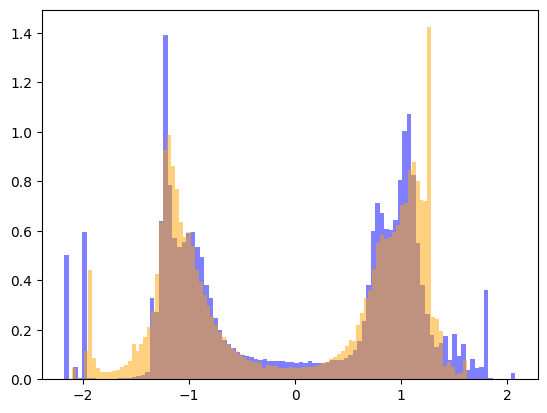

In [12]:
def plot_hists(images1, images2=None):
    # Grafica el histograma de la distribución de valores de las imágenes
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)

    # Si se proporcionan dos conjuntos de imágenes, grafica ambos en el mismo histograma
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show()

# Grafica los histogramas de las imágenes preprocesadas
plot_hists(test_images_medseg, images_radiopedia)

In [13]:
# Convertir máscaras nuevamente a su formato de colores
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()

# Dividir los índices de las imágenes en conjuntos de validación y entrenamiento
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

# Combina imágenes y máscaras de diferentes conjuntos para entrenamiento
train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))

# Asigna los conjuntos de validación
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

# Tamaño del batch igual al número de máscaras de validación
batch_size = len(val_masks)

# Elimina variables grandes de la memoria para liberar espacio
del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

In [14]:
import tensorflow
import albumentations
import cv2

# Dimensiones de origen y destino para las transformaciones de las imágenes
SOURCE_SIZE = 512
TARGET_SIZE = 256

# Definición de las augmentaciones para el conjunto de entrenamiento
train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE),
                                   TARGET_SIZE,
                                   TARGET_SIZE,
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),
])

# Augmentaciones para el conjunto de validación (solo redimensionar)
val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [15]:
from PIL import Image
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import time

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torch

# Si les da error en esta linea, cambiar el entorno de ejecucion a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Clase Dataset personalizada para cargar imágenes y máscaras
class Dataset:
    def __init__(self, images, masks, augmentations=None):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]

    def __getitem__(self, i):
        # Cargar una imagen y su máscara correspondiente
        image = self.images[i]
        mask = self.masks[i]

        # Aplicar augmentaciones si están definidas
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']

        if self.augmentations is None:
            image = Image.fromarray(image)

        # Convertir la imagen a un tensor y normalizarla
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)

        # Convertir la máscara a un tensor largo
        mask = torch.from_numpy(mask).long()

        return image, mask

    def __len__(self):
        # Retorna el número total de imágenes en el conjunto
        return len(self.images)

    def tiles(self, image, mask):
        # Divide una imagen y su máscara en parches más pequeños
        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

# Crear datasets de entrenamiento y validación
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)

# Crear DataLoaders para el entrenamiento y validación
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

cuda


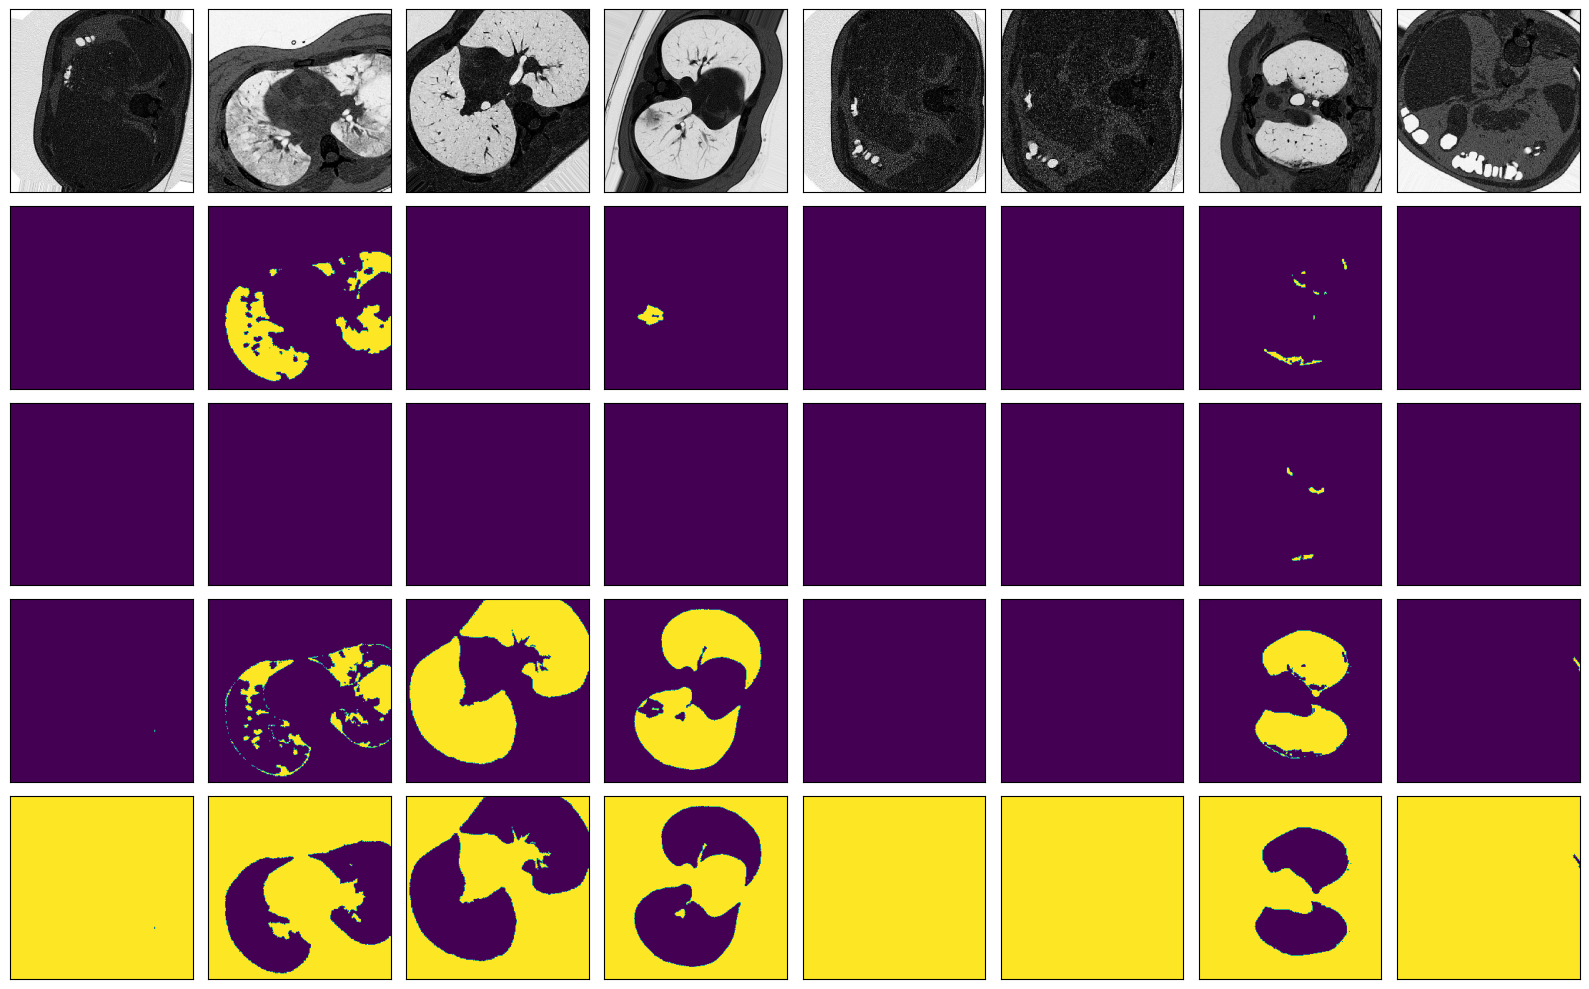

In [16]:
def mask_to_onehot(mask, palette):
    """
    Convierte una máscara de segmentación (H, W, C) a una representación one-hot (H, W, K),
    donde K es el número de clases y C representa el número de canales (1 o 3). Devuelve un tensor one-hot.
    """
    semantic_map = []
    for colour in palette:
        # Comprueba si cada píxel de la máscara coincide con un color en la paleta.
        equality = np.equal(mask, colour)
        # Genera un mapa binario por clase, donde se marcan los píxeles que coinciden con el color.
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)

    # Apila todos los mapas de clase y los convierte a tipo float32.
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    # Convierte el mapa semántico a un tensor de PyTorch.
    return torch.from_numpy(semantic_map)

# Obtener el primer lote de datos del dataloader.
i, train_data = next(enumerate(train_dataloader))

# Convierte la máscara del dataset en un tensor one-hot usando la paleta de colores.
mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1], -1).numpy(), palette)

# Visualiza la imagen original y la máscara codificada en one-hot.
visualize(train_data[0].permute(0, 2, 3, 1), mask_hot_encoded)

In [17]:
def pixel_accuracy(output, mask):
    """
    Calcula la precisión de los píxeles comparando la salida del modelo con la máscara real.
    """
    with torch.no_grad():
        # Aplica softmax y luego toma la clase con mayor probabilidad.
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        # Compara los píxeles predichos con los reales.
        correct = torch.eq(output, mask).int()
        # Calcula la precisión como el ratio de píxeles correctos sobre el total.
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [18]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    """
    Calcula el IoU medio para todas las clases. Es una métrica que mide la intersección sobre la unión
    entre la predicción y la máscara real.
    """
    with torch.no_grad():
        # Aplica softmax para obtener probabilidades, luego selecciona la clase más probable.
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        # Itera sobre cada clase para calcular IoU por clase.
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # Si no hay píxeles para esta clase.
                iou_per_class.append(np.nan)
            else:
                # Calcula la intersección y la unión.
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                # Calcula el IoU usando intersección sobre unión.
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        # Devuelve la media de IoU por clase, ignorando NaN.
        return np.nanmean(iou_per_class)

In [19]:
def iou(pred, gt):
    """
    Calcula el IoU entre la predicción y la verdad de terreno (ground truth).
    """
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    i = float(np.sum(agg == 2))  # Intersección.
    u = float(np.sum(agg > 0))   # Unión.
    # Si no hay unión, IoU es 1, de lo contrario se calcula la fracción.
    if u == 0:
        result = 1
    else:
        result = i / u
    return result

In [20]:
# Definición del modelo U-Net usando EfficientNet como backbone.
model = smp.Unet('efficientnet-b2', in_channels=1, encoder_weights='imagenet',
                 classes=4, activation=None, encoder_depth=5,
                 decoder_channels=[256, 128, 64, 32, 16])
#decoder_attention_type ='scse'

In [21]:
def get_lr(optimizer):
    """
    Devuelve la tasa de aprendizaje actual del optimizador.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    """
    Entrena el modelo a través de múltiples épocas. Monitorea las métricas como pérdida, IoU, y precisión.
    Guarda el modelo si la pérdida de validación mejora.
    """
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf  # Mejor pérdida hasta el momento.
    decrease = 1; not_improve = 0

    model.to(device)
    fit_time = time.time()

    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        model.train()  # Fase de entrenamiento.
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            image = image_tiles.to(device); mask = mask_tiles.to(device)

            # Forward pass.
            output = model(image)
            loss = criterion(output, mask)

            # Cálculo de métricas.
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            # Backpropagation y optimización.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Actualización de la tasa de aprendizaje.
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:  # Validación después de cada época.
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0

            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device); mask = mask_tiles.to(device)
                    output = model(image)

                    # Métricas en la fase de validación.
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            # Almacena las pérdidas promedio de entrenamiento y validación.
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            # Guarda el modelo si la pérdida de validación mejora.
            if min_loss > (test_loss / len(val_loader)):
                print(f'Loss Decreasing.. {min_loss:.3f} >> {(test_loss/len(val_loader)):.3f}')
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, f'Unet_efficientnet_b2_mIoU-{val_iou_score/len(val_loader):.3f}.pt')

            # Si la pérdida no mejora, cuenta cuántas veces no ha mejorado.
            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                # Este hiperparametro lo podemos aumentar para ver si el modelo mejora despues de 7 veces que no decrementa el loss. A lo mejor decrementa despues de 7 iteraciones
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            # Registro de IoU y precisión.
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print(f"Epoch:{e+1}/{epochs}..",
                  f"Train Loss: {running_loss/len(train_loader):.3f}..",
                  f"Val Loss: {test_loss/len(val_loader):.3f}..",
                  f"Train mIoU:{iou_score/len(train_loader):.3f}..",
                  f"Val mIoU: {val_iou_score/len(val_loader):.3f}..",
                  f"Train Acc:{accuracy/len(train_loader):.3f}..",
                  f"Val Acc:{test_accuracy/len(val_loader):.3f}..",
                  f"Time: {(time.time()-since)/60:.2f}m")

    # Devuelve el historial de pérdidas, IoU, precisión y tasas de aprendizaje.
    # Esto más que nada nos ayuda para ver cómo han ido cambiando nuestras variables
    # con cada epoch de entrenamiento
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [22]:
# Valor máximo del learning rate
max_lr = 1e-3
# Número de epochs
epoch = 10
# Penalización de regularización (esto nos ayuda para evitar el overfitting)
weight_decay = 1e-4

# Función de pérdida. Elegimos CrossEntropy porque es la que comúnmente se usa para
# problemas de clasificación
criterion = nn.CrossEntropyLoss()

# Optimizador AdamW para agregarle el weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

# Scheduler para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento.
# Se utiliza OneCycleLR, que ajusta el learning rate entre un valor bajo y el máximo especificado
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

# Aqui se entrena el modelo y guardamos el historial del mismo en una variable para graficar
# los resultados de las variables (loss, score, accuracy, etc) después.
# Le pasamos los conjuntos de train y validation como parámetros, así como la función de
# pérdida, el optimizador AdamW y el Scheduler.
history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.046
Epoch:1/10.. Train Loss: 1.185.. Val Loss: 1.046.. Train mIoU:0.211.. Val mIoU: 0.291.. Train Acc:0.532.. Val Acc:0.710.. Time: 0.54m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.046 >> 0.371
Epoch:2/10.. Train Loss: 0.397.. Val Loss: 0.371.. Train mIoU:0.448.. Val mIoU: 0.412.. Train Acc:0.950.. Val Acc:0.902.. Time: 0.37m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.371 >> 0.269
Epoch:3/10.. Train Loss: 0.143.. Val Loss: 0.269.. Train mIoU:0.463.. Val mIoU: 0.423.. Train Acc:0.968.. Val Acc:0.908.. Time: 0.45m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.269 >> 0.228
saving model...
Epoch:4/10.. Train Loss: 0.092.. Val Loss: 0.228.. Train mIoU:0.505.. Val mIoU: 0.532.. Train Acc:0.972.. Val Acc:0.930.. Time: 0.38m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/10.. Train Loss: 0.070.. Val Loss: 0.268.. Train mIoU:0.605.. Val mIoU: 0.500.. Train Acc:0.980.. Val Acc:0.902.. Time: 0.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.268 >> 0.208
Epoch:6/10.. Train Loss: 0.060.. Val Loss: 0.208.. Train mIoU:0.627.. Val mIoU: 0.564.. Train Acc:0.981.. Val Acc:0.931.. Time: 0.54m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.208 >> 0.202
Epoch:7/10.. Train Loss: 0.054.. Val Loss: 0.202.. Train mIoU:0.647.. Val mIoU: 0.577.. Train Acc:0.982.. Val Acc:0.935.. Time: 0.34m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.202 >> 0.196
Epoch:8/10.. Train Loss: 0.050.. Val Loss: 0.196.. Train mIoU:0.672.. Val mIoU: 0.585.. Train Acc:0.983.. Val Acc:0.938.. Time: 0.51m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.196 >> 0.182
Epoch:9/10.. Train Loss: 0.049.. Val Loss: 0.182.. Train mIoU:0.688.. Val mIoU: 0.597.. Train Acc:0.984.. Val Acc:0.941.. Time: 0.29m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.182 >> 0.179
saving model...
Epoch:10/10.. Train Loss: 0.048.. Val Loss: 0.179.. Train mIoU:0.695.. Val mIoU: 0.595.. Train Acc:0.984.. Val Acc:0.941.. Time: 0.27m
Total time: 3.94 m


In [23]:
# Guardamos el modelo en un archivo
torch.save(model, 'Unet-efficientnet.pt')

In [24]:
# Funciones para graficar los resultados del modelo entrenado
# Función para graficar la pérdida por epoch (Train vs Validation)
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

# Función para graficar el puntaje por epoch (Train vs Validation)
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

# Función para graficar la precisión por epoch (Train vs Validation)
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

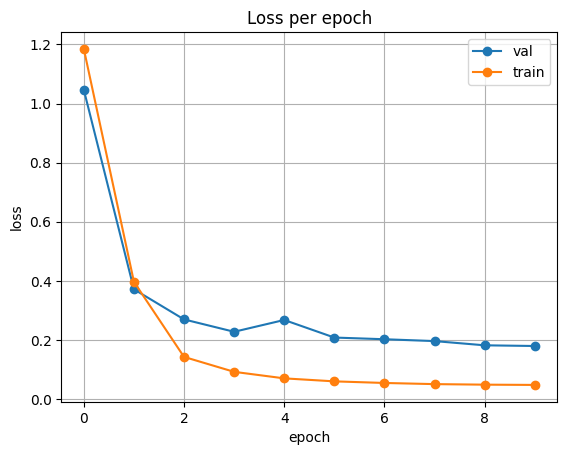

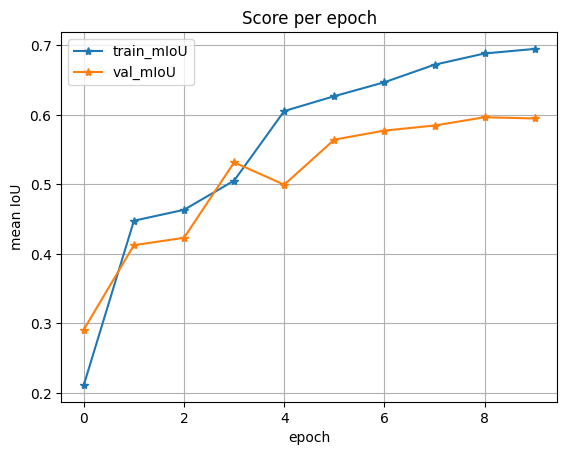

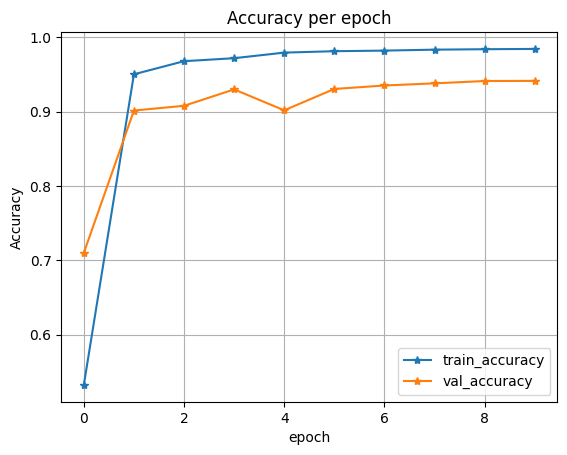

In [25]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# EVALUATION

In [26]:
# Función para predecir la máscara de una imagen y calcular la métrica mIoU
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    # Establecer el modelo en modo de evaluación
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    # Enviar el modelo y las imágenes a la GPU
    model.to(device); image=image.to(device)
    mask = mask.to(device)

    # Desactivar el cálculo de los gradientes, ya que en esta fase no queremos
    # optimizar el modelo sino evaluarlo
    with torch.no_grad():

        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)

        # Obtener la predicción del modelo para la imagen dada
        output = model(image)
        # Obtener la forma de salida (batch size, canales, altura, anchura)
        a, b, c, d = output.shape
        # Calcular el puntaje de IoU medio (mIoU) para la predicción y la máscara real
        score = mIoU(output, mask)
        # Obtener la máscara predicha: argmax selecciona la clase con mayor probabilidad para cada pixel
        masked = torch.argmax(output, dim=1)
        # Mover la máscara a la CPU y eliminar el batch dimension
        masked = masked.cpu().squeeze(0)
    # Devolver la máscara predicha, el puntaje mIoU, y la salida original del modelo
    return masked, score, output.permute(0, 2, 3,1)

In [27]:
# Función para predecir la máscara de una imagen y calcular la precisión a nivel de píxel
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Establecer el modelo en modo de evaluación
    model.eval()

    # Mover el modelo, la imagen y la máscara al dispositivo (GPU si está disponible)
    model.to(device); image=image.to(device)
    mask = mask.to(device)

    # Desactivar los gradientes
    with torch.no_grad():

        # Hacemos la predicción
        output = model(image)
        # Se calcula la precisión por píxel entre la máscara predicha y la real
        acc = pixel_accuracy(output, mask)
        # Se selecciona la clase con mayor probabilidad en cada píxel
        masked = torch.argmax(output, dim=1)
        # Mover la máscara a la CPU y eliminar el batch dimension
        masked = masked.cpu().squeeze(0)
    # Devolver la máscara predicha y la precisión por píxel
    return masked, acc

In [28]:
# Función para convertir una máscara de segmentación en un vector one-hot
def mask_to_onehot(mask, palette):
    """
    Convierte una máscara de segmentación (H, W, C) a (H, W, K), donde el último
    eje es un vector one-hot encoding. K es el número de clases.
    """
    semantic_map = []
    # Iterar sobre los colores en la paleta de clases
    for colour in palette:
        # Comparar cada píxel de la máscara con el color actual
        equality = np.equal(mask, colour)
        # Crear un mapa de clase donde coinciden los colores
        class_map = np.all(equality, axis=-1)
        # Agregar el mapa de clase a la lista
        semantic_map.append(class_map)
    # Apilar los mapas de clase en el último eje y convertirlos a float
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    # Convertir el mapa semántico a un tensor de PyTorch
    return torch.from_numpy(semantic_map)

In [29]:
# Obtener un chunk de imágenes y máscaras del dataloader de validación
image, mask = next(iter(val_dataloader))
# Predecir la máscara
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
# Convertir la máscara real a one-phot encoding usando la paleta de colores definida
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

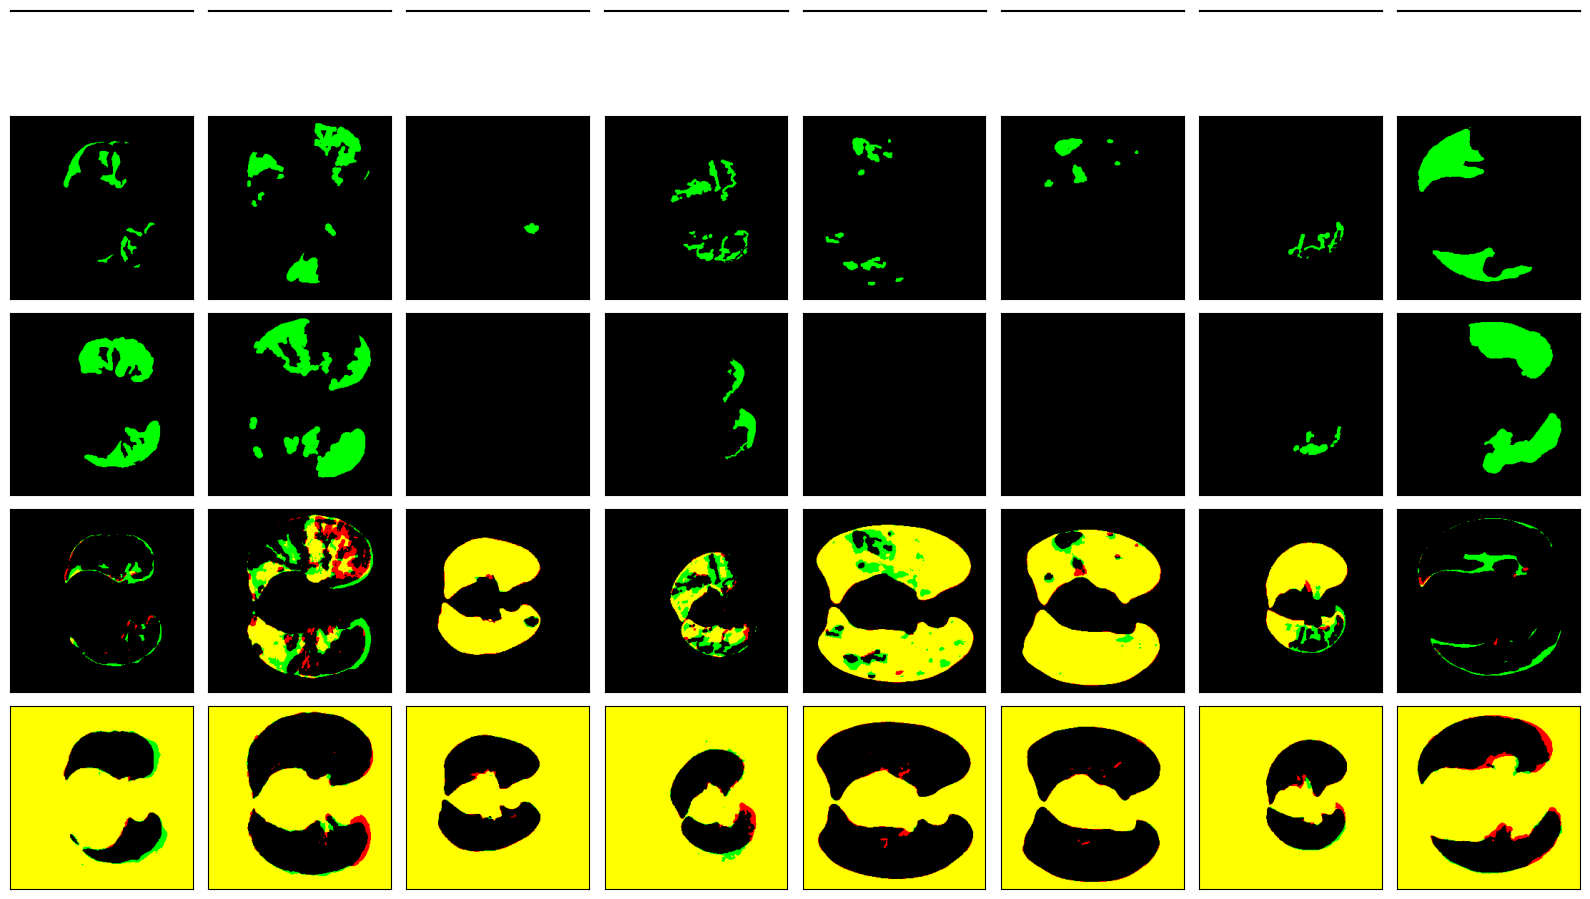

In [30]:
# Visualizar la imagen, el mapa semántico y la predicción del modelo
visualize(image, semantic_map, pred_batch=output)

# Amarillo es Verdadero Positivo (TP), rojo es Falso Positivo (FP), verde es Falso Negativo (FN)

In [31]:
# Función para calcular la puntuación mIoU (mean Intersection over Union) en un conjunto de prueba
def miou_score(model, test_set):
  # Lista para almacenar las puntuaciones de IoU
    score_iou = []
    # Iterar sobre el conjunto de prueba (test_set) utilizando tqdm para mostrar el progreso
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        # Predecir la máscara y calcular la puntuación mIoU usando la función predict_image_mask_miou
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        # Agregar la puntuación de mIoU a la lista
        score_iou.append(score)
    # Devolver los puntajes IoU
    return score_iou

In [32]:
# Calcular la puntuación mIoU del modelo en el conjunto de validación
mob_miou = miou_score(model, val_dataloader)
mob_miou

  0%|          | 0/1 [00:00<?, ?it/s]

[0.5948333776496058]

In [33]:
# Eliminamos las imágenes y máscaras de entrenamiento para liberar memoria
del train_images
del train_masks

In [34]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    # Composición de transformaciones para la imagen: conversión a tensor y normalización
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # Aplicar las transformaciones a la imagen
    image = t(image)
    # Establecer el modo evaluacion para train
    model.eval()

    # Mover el modelo y la imagen al GPU
    model.to(device)
    image = image.to(device)

    # Desactivar el cálculo de los gradientes
    with torch.no_grad():
        # Realizar la predicción añadiendo una dimensión a la imagen para el batch
        output = model(torch.unsqueeze(image,1))
        # Aplicamos Softmax para obtener claramente las probabilidades de cada clase
        output = nn.Softmax(dim=1)(output)

    # Mover el resultado a la CPU y convertirlo a NumPy
    return output.permute(0, 2, 3, 1).cpu().numpy()


In [35]:
def visualize_final(image_batch, mask_batch=None, num_samples=8, hot_encode=True, alpha=0.7):
    """
    Visualiza las imágenes originales junto con la máscara superpuesta con una opacidad.
    """
    fig, ax = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))

    for i in range(num_samples):
        ax_image = ax[i]

        # Mostrar la imagen original en escala de grises
        if hot_encode:
            ax_image.imshow(image_batch[i, :, :, 0], cmap='Greys')  
        else:
            ax_image.imshow(image_batch[i, :, :])

        # Si hay una máscara, hacer el overlap con la opacidad (alpha)
        if mask_batch is not None:
            # Usamos solo la primera clase de la máscara
            mask_to_show = mask_batch[i, :, :, 0]
            ax_image.imshow(mask_to_show, cmap='YlOrRd', alpha=alpha)

        # Eliminamos los ticks del eje
        ax_image.set_xticks([])
        ax_image.set_yticks([])

    # Ajustamos el layout para mejorar la visualización
    plt.tight_layout()
    plt.show()

torch.Size([10, 256, 256, 1])
(256, 256, 1)
(10, 256, 256, 4)


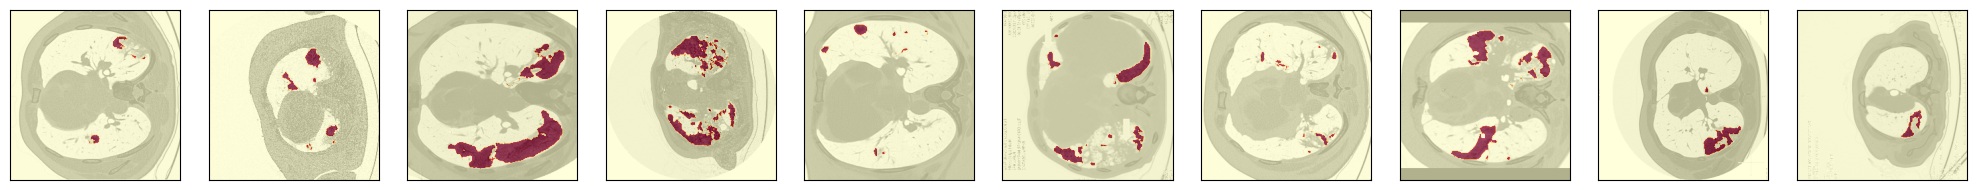

In [36]:
# Crear un batch de imágenes de prueba aplicando las transformaciones de validación
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
#output = test_predict(model, torch.from_numpy(image_batch).permute(0, 3, 1,2))
# Inicializar un array para almacenar las predicciones asignadno los valores para el tamaño
# del batch, altura, ancho y canales, respectivamente.
output = np.zeros((10,256,256,4))
# Bucle para realizar predicciones sobre cada imagen en el batch
for i in range(10):
    output[i] = test_predict(model, image_batch[i])
print(output.shape)
# Hacemos las máscaras de predicción de forma binaria (clase 0 o clase 1) con un threshold de 0.5
test_masks_prediction = output > 0.5
# Visualizar las imágenes de prueba junto con las máscaras de predicción
visualize_final(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

In [37]:
import scipy
# Redimensionar las máscaras predichas a su tamaño original utilizando interpolación
# El factor de ampliación es 2x en las dimensiones espaciales (height, width)
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [38]:
import pandas as pd

# Convertir las máscaras redimensionadas a un archivo CSV
pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())),
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1),
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')